In [1]:
import pandas as pd
import numpy as np

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.graphics.tsaplots as tsg
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA

from datetime import datetime, date

In [2]:
df_raw = pd.read_csv('./data/00_original/Lake_Bilancino.csv', sep=',', header=0, index_col=0)

df = df_raw[['Lake_Level']].copy()
df.index = pd.to_datetime(df.index, format = '%d/%m/%Y')
df = df.asfreq('d')
df.head(5)

,Lake_Level
Date,
2002-06-03,249.43
2002-06-04,249.43
2002-06-05,249.43
2002-06-06,249.43
2002-06-07,249.44


In [3]:
df['Lake_Level'] -= (251 - 31)
print(df.isna().sum())

Lake_Level    0
dtype: int64


<AxesSubplot:xlabel='Date'>

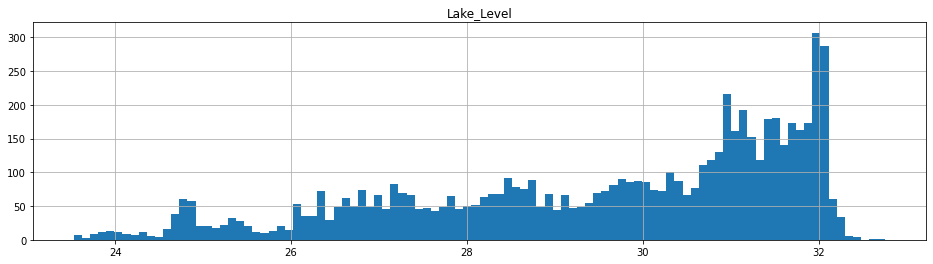

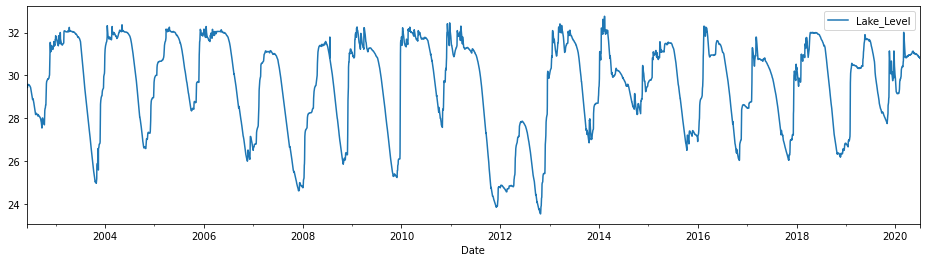

In [4]:
df.hist(figsize=(16, 4), bins=100)
df.plot(figsize=(16, 4))

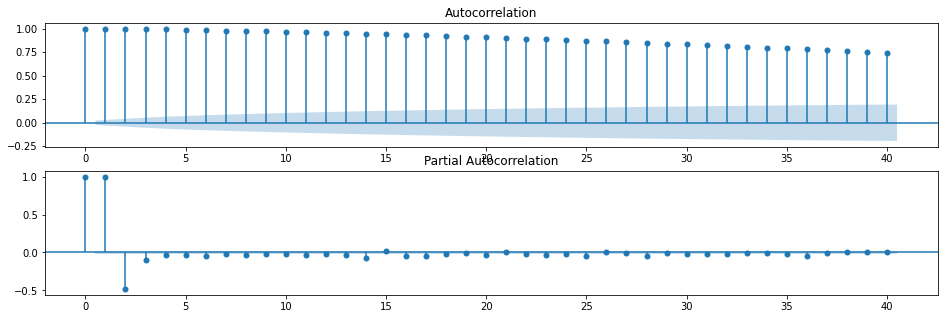

In [5]:
# SEASONALITY CHECK

fig, ax = plt.subplots(2, 1, figsize=(16, 5))

tsg.plot_acf(df['Lake_Level'],lags=40, ax=ax[0])
tsg.plot_pacf(df['Lake_Level'],lags=40, ax=ax[1])
plt.show()

Text(0, 0.5, 'Residual')

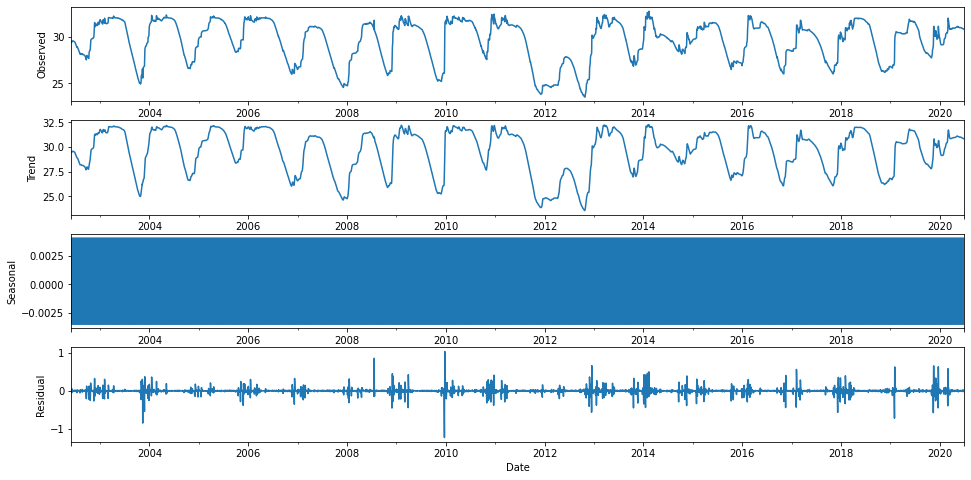

In [6]:
result = seasonal_decompose(df['Lake_Level'], model='additive')

fig, ax = plt.subplots(4,1, figsize=(16, 8))

result.observed.plot(ax=ax[0])
ax[0].set_ylabel('Observed')
result.trend.plot(ax=ax[1])
ax[1].set_ylabel('Trend')
result.seasonal.plot(ax=ax[2]) # blue square = no cyclical pattern because value is constantly jumping up and down
ax[2].set_ylabel('Seasonal')
result.resid.plot(ax=ax[3])
ax[3].set_ylabel('Residual')

Lake_Level ADF = -6.880991194599921
Lake_Level p-value = 1.4336336890483035e-09
           is NOT a stationary variable!


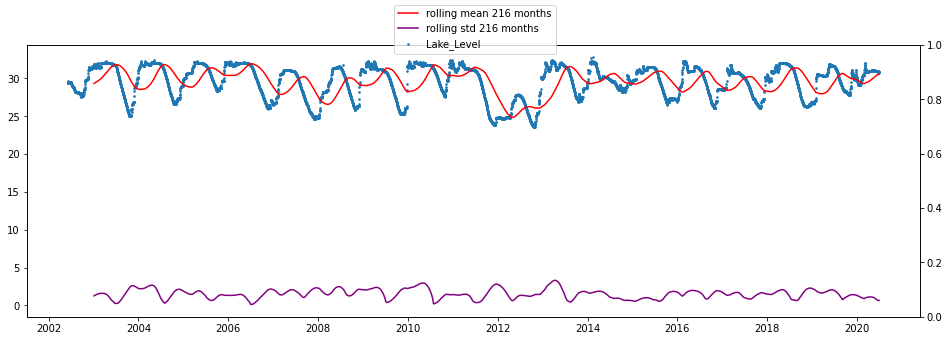

In [28]:
# STATIONARITY
# Stationarity check means that we have constant mean and variance of the data over the time.
# We can inspect visually or use Dickey-Fuller statistical test.

# TODO HERE PLOT LAKE_LEVEL WITH ROLLING AVG AND STD

# Dickey-Fuller statisticall test:
# Is trying to reject the null hypothesis that the data is non-stationary.
# If we reject the test means that data is stationary
#    if p <= 0.05 we reject the null hypothesis and data is stationary
#    if p >  0.05 we accept the null hypothesis and data is non-stationary

adf_test = sts.adfuller(df['Lake_Level']) # Lake_Level is non-stationary

print('Lake_Level ADF = {}'.format(str(adf_test[0])))
print('Lake_Level p-value = {}'.format(str(adf_test[1])))
print('           is NOT a stationary variable!')

fig, ax = plt.subplots(1, 1, figsize=(16, 5))

ax.scatter(x=df.index, y=df['Lake_Level'], label='Lake_Level', marker='.', s=10, alpha=1)
ax2 = ax.twinx()

months = int(((max(df.index) - min(df.index))/np.timedelta64(1, 'M')))

ax.plot(df['Lake_Level'].rolling(months).mean(), color='red', label='rolling mean {} months'.format(months))
ax.plot(df['Lake_Level'].rolling(months).std(), color='purple', label='rolling std {} months'.format(months))
fig.legend(loc='upper center')

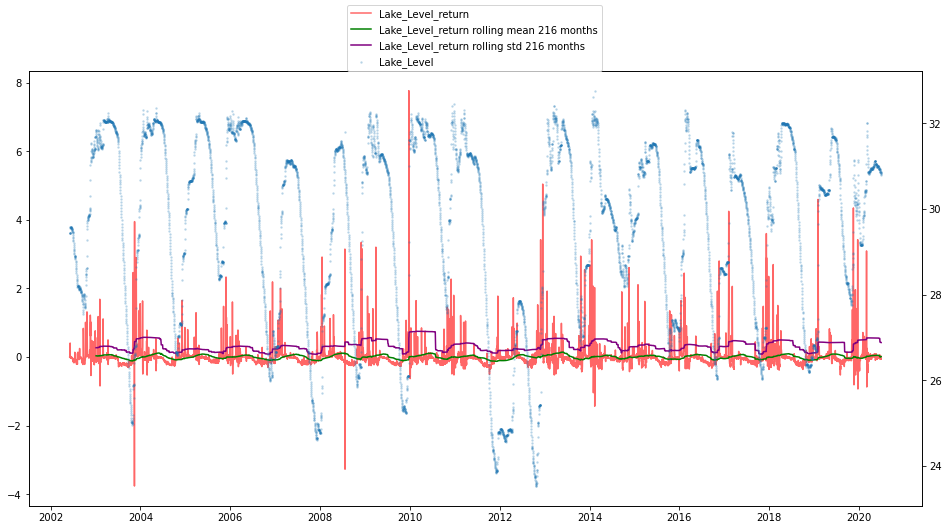

In [32]:
# Because lake level is not stationary we need to transform it to returns and then plot mean and std

df['Lake_Level_return'] = df['Lake_Level'].pct_change(1).mul(100)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(df['Lake_Level_r'], color='red', alpha=0.6, label='Lake_Level_return')
ax.plot(df['Lake_Level_r'].rolling(months).mean(), color='green', label='Lake_Level_return rolling mean {} months'.format(months))
ax.plot(df['Lake_Level_r'].rolling(months).std(), color='purple', label='Lake_Level_return rolling std {} months'.format(months))

ax2 = ax.twinx()
ax2.scatter(x=df.index, y=df['Lake_Level'], label='Lake_Level', marker='.', s=10, alpha=0.2)

fig.legend(loc='upper center')

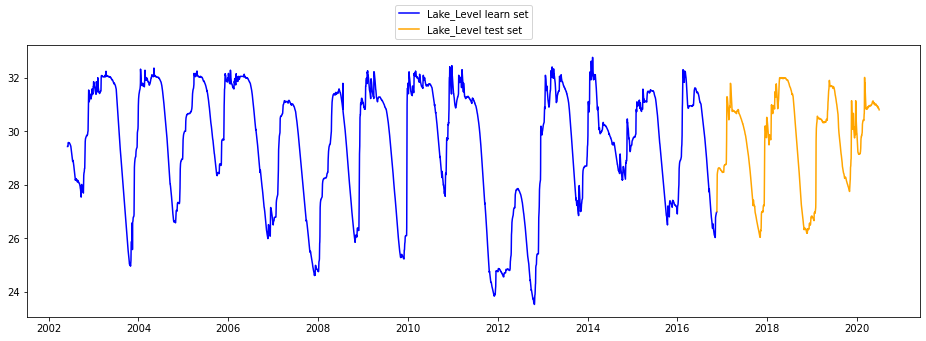

In [33]:
test_percentage = 0.2

split = int(len(df) * (1 - test_percentage))
df_learn = df.iloc[:split]
df_test = df.iloc[split:]

fig, ax = plt.subplots(1, 1, figsize=(16, 5))

ax.plot(df_learn['Lake_Level'], color='blue', label='Lake_Level learn set')
ax.plot(df_test['Lake_Level'], color='orange', label='Lake_Level test set')
fig.legend(loc='upper center')

In [10]:
# from statsmodels.tsa.arima.model import ARIMA

# model = ARIMA(df_learn['Lake_Level'], order=(5,1,0))
# model_fit = model.fit()

# model_fit.summary()